# Convolutional Neural Network for QPE

Let's test our QPE approach with CNN.

In [16]:
import os, csv, logging, argparse, glob, h5py, pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten, Activation
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras.utils import normalize, to_categorical

# Parameters
nLayer = 6                      # 6 10-min dbz for an hour
nY = 275                        # y-dimension of dbz data
nX = 162                        # x-dimension of dbz data
batchSize = 128                 # Batch size for training / testing
prec_bins=[0, 0.5, 10, 15, 30, 1000]
yseg_stat = [0.5, 8, 13, 29]    # 40-year statistics of hourly precipitation of trace, 90%, 95%, and 99% percentile
yseg = [0.5, 10, 15, 30]        # Actual segmentation for precipitation

#-----------------------------------------------------------------------
# Functions
#-----------------------------------------------------------------------
# Load input/output data for model
def loadIOTab(srcx, srcy, dropna=False):
    import pandas as pd
    # Read raw input and output
    #logging.info("Reading input X from: "+ srcx)
    print("Reading input X from: "+ srcx)
    xfiles = []
    for root, dirs, files in os.walk(srcx): 
        for fn in files: 
            if fn.endswith('.npy'): 
                 xfiles.append({'date':fn.replace('.npy',''), 'xuri':os.path.join(root, fn)})
    xfiles = pd.DataFrame(xfiles)
    print("... read input size: "+str(xfiles.shape))
    #logging.info("Reading output Y from: "+ srcy)
    print("Reading output Y from: "+ srcy)
    yraw = pd.read_csv(srcy, encoding='utf-8')
    yraw['date'] = yraw['date'].apply(str)
    print("... read output size: "+str(yraw.shape))
    # Create complete IO-data
    print("Pairing X-Y and splitting training/testing data.")
    iotab = pd.merge(yraw, xfiles, on='date', sort=True)
    print("... data size after merging: "+str(iotab.shape))
    # Dro NA if specified
    if dropna:
        print('Dropping records with NA')
        iotab = iotab.dropna()
        print("... data size after dropping-NAs: "+str(iotab.shape))
    # Generate weited sampling

    # Done
    return(iotab)

def generate_equal_samples(iotab, prec_bins, ylab='y', shuffle=True):
    '''Create equal sampling list: 
           repeat sample rare categories to mtach the frequency of the majority case.
    '''
    # Analysis the Precipitation
    prec_hist = np.histogram(iotab[ylab], bins=prec_bins)
    maxc = np.max(prec_hist[0])                     # Count the most frequent category
    nrep = np.round(maxc/prec_hist[0]).astype(int)  # Multiples required to reach max-count
    # Categorize precipitation by specified bins
    iotab['prec_cat'] = np.digitize(iotab[ylab], bins=prec_bins[1:-1])
    logging.debug('Sample histogram before weighted sampling:')
    logging.debug(iotab['prec_cat'].value_counts())
    # Repeat sampling by p
    for icat in range(0,len(prec_bins)-1):
        repeat_n = nrep[icat]
        tmp = iotab.loc[iotab['prec_cat']==icat,:]
        print('Append data category: '+str(icat)+' for '+ str(repeat_n) +' times with size '+str(tmp.shape))
        for j in range(int(repeat_n)-1):
            iotab = iotab.append(tmp, ignore_index=True)
    logging.debug('Sample histogram after weighted sampling:')
    logging.debug(iotab['prec_cat'].value_counts().sort_index())
    # Shuffle new dataset if specified
    if shuffle:
        iotab = iotab.sample(frac=1)#.reset_index(drop=True)
    #
    return(iotab)

def loadDBZ(flist):
    ''' Load a list a dbz files (in npy format) into one numpy array. '''
    xdata = []
    for f in flist:
        tmp = np.load(f)
        xdata.append(tmp)
    x = np.array(xdata, dtype=np.float32)
    return(x)

# Function to give report
def report_evaluation(y_true, y_pred, verbose=0):
    import sklearn.metrics as metrics
    # Calculate measures
    results = {}
    results['y_true_mean'] = y_true.mean()
    results['y_true_var'] = y_true.var()
    results['y_pred_mean'] = y_pred.mean()
    results['y_pred_var'] = y_pred.var()
    results['rmse'] = np.sqrt(metrics.mean_squared_error(y_true,y_pred))
    if y_pred.var()<=10e-8:
        results['corr'] = 0
    else:
        results['corr'] = np.corrcoef(y_true,y_pred)[0,1]
    # Print results if verbose > 0
    if verbose>0:
        if verbose>1:
            print('Mean of y_true: ' + str(results['y_true_mean']))
            print('Variance of y_true: ' + str(results['y_true_var']))
            print('Mean of y_pred: ' + str(results['y_pred_mean']))
            print('Variance of y_pred: ' + str(results['y_pred_var']))
        print('RMSE: ' + str(results['rmse']))
        print('Corr: ' + str(results['corr']))
    # Return results
    return(results)

# Create cross validation splits
def create_CV_splits(iotable, k=5, ysegs=None, ylab='y', shuffle=False):
    from sklearn.model_selection import StratifiedKFold, KFold
    # Index of each fold
    cvidx_train = []
    cvidx_test = []
    # If segmentation of y is not specified, use simple KFold
    if ysegs is None:
        kf = KFold(n_splits=k, random_state=None, shuffle=shuffle)
        for idx_train, idx_test in kf.split(iotable['xuri']):
            cvidx_train.append(idx_train)
            cvidx_test.append(idx_test)
    else:
        kf = StratifiedKFold(n_splits=k, random_state=None, shuffle=shuffle)
        for idx_train, idx_test in kf.split(iotable['xuri'], np.digitize(iotable[ylab], ysegs)):
            cvidx_train.append(idx_train)
            cvidx_test.append(idx_test)
    return((cvidx_train, cvidx_test))

# CNN
def init_model_reg(input_shape):
    """
    :Return: 
      Newly initialized model (regression).
    :param 
      int input_shape: The number of variables to use as input features.
    """
    # Input layer
    inputs = Input(shape=input_shape)
    # blovk1: CONV -> CONV -> MaxPooling
    x = Conv2D(filters=32, kernel_size=(3,3), activation='relu', name='block1_conv1', data_format='channels_first')(inputs)
    x = BatchNormalization(axis=1)(x)
    x = MaxPooling2D((2,2), name='block1_pool', data_format='channels_first')(x)
    x = Dropout(0.25)(x)
    # block2: CONV -> CONV -> MaxPooling
    x = Conv2D(64, (3,3), activation='relu', name='block2_conv1',data_format='channels_first')(x)
    x = BatchNormalization(axis=1)(x)
    x = Conv2D(64, (3,3), activation='relu', name='block2_conv2',data_format='channels_first')(x)
    x = BatchNormalization(axis=1)(x)
    x = MaxPooling2D((2,2), name='block2_pool', data_format='channels_first')(x)
    x = Dropout(0.25)(x)
    # block3: CONV -> CONV -> MaxPooling
    x = Conv2D(128, (3,3), activation='relu', name='block3_conv1',data_format='channels_first')(x)
    x = BatchNormalization(axis=1)(x)
    x = Conv2D(128, (3,3), activation='relu', name='block3_conv2',data_format='channels_first')(x)
    x = BatchNormalization(axis=1)(x)
    x = MaxPooling2D((2,2), name='block3_pool', data_format='channels_first')(x)
    x = Dropout(0.25)(x)
    # Output block: Flatten -> Dense -> Dense -> softmax output
    x = Flatten()(x)
    x = Dense(256, activation='relu', name='fc1')(x)
    x = BatchNormalization(axis=1)(x)
    x = Dropout(0.5)(x)
    x = Dense(16, activation='relu', name='fc2')(x)
    x = BatchNormalization(axis=1)(x)
    # Output layer
    out = Dense(1, activation='linear', name='main_output')(x)
    # Initialize model
    model = Model(inputs = inputs, outputs = out)
    # Define compile parameters
    adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    #sgd = SGD(lr=0.01, momentum=1e-8, decay=0.001, nesterov=True)#, clipvalue=1.)
    model.compile(loss='mse', optimizer=adam, metrics=['mae','cosine_similarity'])
    return(model)

def y_to_log(y):
    ''' Convert the y to log(y+1). '''
    ylog = np.log(y+1).astype(np.float32)
    return(ylog)

def log_to_y(y):
    ''' Convert the predicted y in log-scale back to original scale. '''
    yori = (np.exp(y.flatten())-1.0).astype(np.float32)
    yori[yori<0.5] = 0.                          # Set the minimal values to 0.
    return(yori)

def data_generator_reg(iotab, batch_size, ylab='y', logy=False):
    ''' Data generator for batched processing. '''
    nSample = len(iotab)
    y = np.array(iotab[ylab], dtype=np.float32).reshape(nSample, 1)
    #print(y[:5])
    # This line is just to make the generator infinite, keras needs that    
    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < nSample:
            limit = min(batch_end, nSample)
            X = loadDBZ(iotab['xuri'][batch_start:limit])
            if logy:
                Y = y_to_log(y[batch_start:limit])
            else:
                Y = y[batch_start:limit]/100.
            #print(X.shape)
            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     
            batch_start += batch_size   
            batch_end += batch_size
    # End of generator

# Function to give report
def report_evaluation(y_true, y_pred, verbose=0):
    import sklearn.metrics as metrics
    # Calculate measures
    results = {}
    results['y_true_mean'] = y_true.mean()
    results['y_true_var'] = y_true.var()
    results['y_pred_mean'] = y_pred.mean()
    results['y_pred_var'] = y_pred.var()
    results['rmse'] = np.sqrt(metrics.mean_squared_error(y_true,y_pred))
    if y_pred.var()<=10e-8:
        results['corr'] = 0
    else:
        results['corr'] = np.corrcoef(y_true,y_pred)[0,1]
    # Print results if verbose > 0
    if verbose>0:
        if verbose>1:
            print('Mean of y_true: ' + str(results['y_true_mean']))
            print('Variance of y_true: ' + str(results['y_true_var']))
            print('Mean of y_pred: ' + str(results['y_pred_mean']))
            print('Variance of y_pred: ' + str(results['y_pred_var']))
        print('RMSE: ' + str(results['rmse']))
        print('Corr: ' + str(results['corr']))
    # Return results
    return(results)

## Data Preparation

In [2]:
logging.basicConfig(level=logging.DEBUG)
srcx = '../dbz_2016070609/'
srcy = './data/1hrmax.csv'
# Create IO table
iotab = loadIOTab(srcx, srcy, dropna=True)
# Create weighted sampling rom IOdata
newiotab = generate_equal_samples(iotab, prec_bins=prec_bins, ylab='t1hr', shuffle=True)
#
print(iotab.shape)
print(newiotab.shape)
print(iotab['prec_cat'].value_counts().sort_index())
print(newiotab['prec_cat'].value_counts().sort_index())

Reading input X from: ../dbz_2016070609/
... read input size: (92, 2)
Reading output Y from: ./data/1hrmax.csv
... read output size: (35064, 2)
Pairing X-Y and splitting training/testing data.
... data size after merging: (92, 3)
Dropping records with NA
... data size after dropping-NAs: (92, 3)
Append data category: 0 for 2 times with size (23, 4)
Append data category: 1 for 1 times with size (50, 4)
Append data category: 2 for 6 times with size (9, 4)
Append data category: 3 for 7 times with size (7, 4)
Append data category: 4 for 17 times with size (3, 4)
(92, 4)
(250, 4)
0    23
1    50
2     9
3     7
4     3
Name: prec_cat, dtype: int64
0    46
1    50
2    54
3    49
4    51
Name: prec_cat, dtype: int64


In [27]:
tf.random.set_seed(11223)

model = init_model_reg((nLayer, nY, nX))
model.summary()
steps_train = np.ceil(newiotab.shape[0]/32)
hist = model.fit_generator(data_generator_reg(newiotab, 32, ylab='t1hr', logy=True), steps_per_epoch=steps_train, epochs=10, max_queue_size=32, verbose=0)

print(pd.DataFrame(hist.history))

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 6, 275, 162)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 273, 160)      1760      
_________________________________________________________________
batch_normalization_31 (Batc (None, 32, 273, 160)      128       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 136, 80)       0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 32, 136, 80)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 134, 78)       18496     
_________________________________________________________________
batch_normalization_32 (Batc (None, 64, 134, 78)       256 

In [32]:
steps_test = np.ceil(iotab.shape[0]/32)
y_pred = model.predict_generator(data_generator_reg(iotab, 32, ylab='t1hr', logy=True), steps=steps_test, verbose=0)
yt = iotab['t1hr']
print(iotab.shape)
print(y_pred.shape)

ys = pd.DataFrame({'y': yt, 'y_pred': y_pred.flatten()}) 
tmp = report_evaluation(yt, log_to_y(y_pred.flatten()))
print(tmp)
print(pd.DataFrame(hist.history))

(92, 4)
(92, 1)
{'y_true_mean': 6.167391304347827, 'y_true_var': 87.12112279025324, 'y_pred_mean': 11503.65, 'y_pred_var': 3657448700.0, 'rmse': 61556.76856536317, 'corr': 0.3606873558954723}
       loss       mae  cosine_similarity
0  6.732636  2.050690              0.480
1  2.336294  1.212178              0.728
2  1.773756  1.041369              0.712
3  1.209113  0.860449              0.784
4  0.835705  0.721309              0.760
5  0.656173  0.642522              0.808
6  0.568471  0.601700              0.792
7  0.517210  0.582025              0.800
8  0.405730  0.494116              0.792
9  0.350086  0.464623              0.800


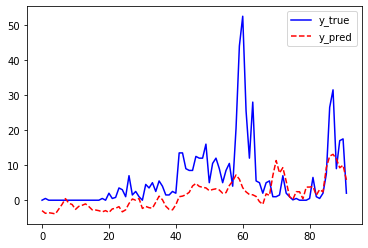

W1101 13:02:44.188796 16152 legend.py:1282] No handles with labels found to put in legend.


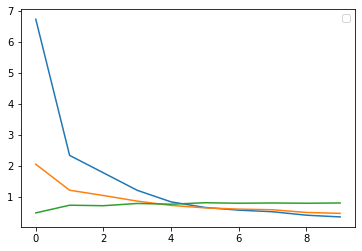

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(ys['y'], 'b-', label='y_true')
plt.plot(ys['y_pred'], 'r--', label='y_pred')
plt.legend()
plt.show()

plt.plot(pd.DataFrame(hist.history))
plt.legend()
plt.show()

In [ ]:
print(ys.iloc[:30,:])

## Summary

- The trend seems correct though the magnitude is smaller.
- Effect of increasing epochs seems stopped around 15
- 